In [2]:
import zipfile
import joblib
import yaml
import io
from pathlib import Path

class ScalingZipLoader:
    def __init__(self, zip_path):
        self.zip_path = Path(zip_path)
        if not self.zip_path.exists():
            raise FileNotFoundError(f"❌ ไม่พบไฟล์ ZIP: {zip_path}")

        self.scaler_in = None
        self.scaler_out = None
        self.metadata = None

    def load(self):
        """โหลด input/output scaler และ metadata จาก ZIP"""
        with zipfile.ZipFile(self.zip_path, "r") as zipf:
            # ✅ โหลด input_scaler.pkl
            with zipf.open("input_scaler.pkl") as f:
                buffer = io.BytesIO(f.read())
                self.scaler_in = joblib.load(buffer)

            # ✅ โหลด output_scaler.pkl
            with zipf.open("output_scaler.pkl") as f:
                buffer = io.BytesIO(f.read())
                self.scaler_out = joblib.load(buffer)

            # ✅ โหลด metadata.yaml
            with zipf.open("metadata.yaml") as f:
                self.metadata = yaml.safe_load(f)

        print(f"📦 Loaded ZIP successfully: {self.zip_path}")
        return self.scaler_in, self.scaler_out, self.metadata


if __name__ == "__main__":
    # 🧪 ตัวอย่างการใช้งาน
    zip_file = r"D:\Project_end\New_world\my_project\config\Test_scale1_scalers.zip"
    loader = ScalingZipLoader(zip_file)
    scaler_in, scaler_out, metadata = loader.load()

    print("\n🎯 Metadata summary:")
    print(yaml.dump(metadata, allow_unicode=True, sort_keys=False))

    # ✅ ตัวอย่างการใช้งาน scaler
    import numpy as np
    sample_input = np.array([[0.5]])
    scaled_input = scaler_in.transform(sample_input)
    print("\nSample input 0.5 scaled:", scaled_input)


📦 Loaded ZIP successfully: D:\Project_end\New_world\my_project\config\Test_scale1_scalers.zip

🎯 Metadata summary:
project:
  name: RC_Tank_RL_Control
  version: 1.1.0
  created_by: DataScience Team
  created_at: '2025-10-11 16:31:24'
  updated_at: '2025-10-11 16:31:24'
dataset:
  name: Test_scale1
  source_files:
  - pwm_duty_0.00_freq_0.01_pwm.csv
  - pwm_duty_0.11_freq_0.01_pwm.csv
  - pwm_duty_0.22_freq_0.01_pwm.csv
  - pwm_duty_0.33_freq_0.01_pwm.csv
  - pwm_duty_0.44_freq_0.01_pwm.csv
  - pwm_duty_0.56_freq_0.01_pwm.csv
  - pwm_duty_0.67_freq_0.01_pwm.csv
  - pwm_duty_0.78_freq_0.01_pwm.csv
  - pwm_duty_0.89_freq_0.01_pwm.csv
  - pwm_duty_1.00_freq_0.01_pwm.csv
  total_rows: 30000
  input_features:
  - DATA_INPUT
  output_features:
  - DATA_OUTPUT
scaling:
  method: MinMaxScaler
  parameters:
    input:
      min:
      - 0.0
      scale:
      - 0.041666666666666664
      data_min:
      - 0.0
      data_max:
      - 24.0
      feature_range:
      - 0
      - 1
    output:
    

Epoch 1/50, Loss: 0.177768
Epoch 5/50, Loss: 0.000320
Epoch 10/50, Loss: 0.000067
Epoch 15/50, Loss: 0.000021
Epoch 20/50, Loss: 0.000007
Epoch 25/50, Loss: 0.000003
Epoch 30/50, Loss: 0.000003
Epoch 35/50, Loss: 0.000003
Epoch 40/50, Loss: 0.000004
Epoch 45/50, Loss: 0.000006
Epoch 50/50, Loss: 0.000004


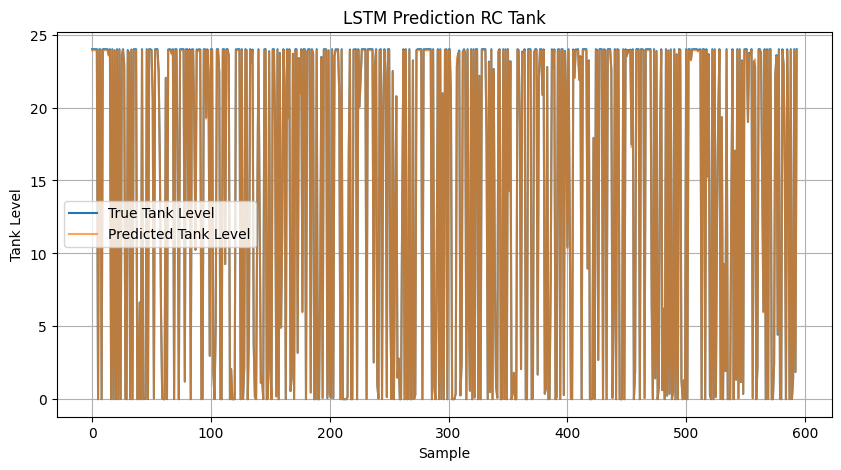

In [3]:
# -----------------------------
# LSTM RC Tank Prediction Example
# -----------------------------
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

# -----------------------------
# Load dataset
# -----------------------------
data_file = r"D:\Project_end\New_world\my_project\data\raw\pwm_duty_0.56_freq_0.01_pwm.csv"
df = pd.read_csv(data_file)

# -----------------------------
# Load scalers (จาก ZIP ก็ได้)
# -----------------------------
# ตัวอย่างใช้ MinMaxScaler ใหม่
input_features = ["DATA_INPUT", "DATA_OUTPUT"]
output_features = ["DATA_OUTPUT"]

scaler_in = MinMaxScaler()
scaler_out = MinMaxScaler()

X_scaled = scaler_in.fit_transform(df[input_features].values)
y_scaled = scaler_out.fit_transform(df[output_features].values)

# -----------------------------
# สร้าง sequences สำหรับ LSTM
# -----------------------------
window_size = 30

def create_sequences(X, y, window_size=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size=window_size)

# แบ่ง train/val/test
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# แปลงเป็น torch.Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# -----------------------------
# สร้าง LSTM model
# -----------------------------
class LSTM_Predictor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
output_size = y_train.shape[1]

model = LSTM_Predictor(input_size=input_size, hidden_size=64, num_layers=2, output_size=output_size)

# -----------------------------
# Training setup
# -----------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50
batch_size = 64

# -----------------------------
# Training loop
# -----------------------------
for epoch in range(epochs):
    permutation = torch.randperm(X_train.size(0))
    epoch_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X_train[indices], y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)

    epoch_loss /= X_train.size(0)
    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}")

# -----------------------------
# Test & Plot
# -----------------------------
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()

# แปลงกลับ scale เดิม
y_pred_orig = scaler_out.inverse_transform(y_pred)
y_test_orig = scaler_out.inverse_transform(y_test.numpy())

plt.figure(figsize=(10,5))
plt.plot(y_test_orig, label="True Tank Level")
plt.plot(y_pred_orig, label="Predicted Tank Level", alpha=0.7)
plt.legend()
plt.xlabel("Sample")
plt.ylabel("Tank Level")
plt.title("LSTM Prediction RC Tank")
plt.grid(True)
plt.show()


In [ ]:
import sys
from pathlib import Path

# project_root = my_project
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print("✅ Project root added to sys.path:", project_root)

✅ Project root added to sys.path: D:\Project_end\New_world\my_project


In [ ]:
import src.models.lstm_model
print(dir(src.models.lstm_model))

['LSTMForecaster', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'nn', 'torch']


In [4]:
%run setup_path.py

import torch
from src.data.scaling_loader import ScalingZipLoader
from src.data.sequence_builder import create_sequences
from src.models.lstm_model import LSTM_MODEL
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from src.utils.logger import Logger
import pandas as pd



# ===========================
# 1️⃣ Configuration
# ===========================
DATA_FILE = Path(r"D:\Project_end\New_world\my_project\data\raw\pwm_duty_0.56_freq_0.01_pwm.csv")
SCALER_ZIP = Path(r"D:\Project_end\New_world\my_project\config\Test_scale1_scalers.zip")
WINDOW_SIZE = 10
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(DEVICE)
# ===========================
# 2️⃣ Load data
# ===========================
df = pd.read_csv(DATA_FILE)
X_raw = df[["DATA_INPUT"]].values
y_raw = df[["DATA_OUTPUT"]].values

# ===========================
# 3️⃣ Load scalers
# ===========================
scaler_loader = ScalingZipLoader(SCALER_ZIP)
X_scaled = scaler_loader.transform_input(X_raw)
y_scaled = scaler_loader.inverse_output(y_raw)  # หรือ transform_output ถ้ามี

# ===========================
# 4️⃣ Create sequences
# ===========================
X_seq, y_seq = create_sequences(np.column_stack((X_scaled, y_scaled)), window_size=WINDOW_SIZE)

# ===========================
# 5️⃣ Train/Val split
# ===========================
dataset = TensorDataset(torch.tensor(X_seq, dtype=torch.float32),
                        torch.tensor(y_seq, dtype=torch.float32))
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ===========================
# 6️⃣ Model & Optimizer
# ===========================
input_dim = X_seq.shape[2]
model = LSTM_MODEL(input_dim=input_dim, hidden_dim=64, output_dim=1, stateful=False).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ===========================
# 7️⃣ Logger
# ===========================
logger = Logger()

# ===========================
# 8️⃣ Training Loop
# ===========================
for epoch in range(1, EPOCHS+1):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE).unsqueeze(-1)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    
    epoch_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE).unsqueeze(-1)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)

    # Log
    logger.add_data_log(["epoch", "train_loss", "val_loss"], [[epoch], [epoch_loss], [val_loss]])
    print(f"Epoch {epoch:03d} | Train Loss: {epoch_loss:.6f} | Val Loss: {val_loss:.6f}")

# ===========================
# 9️⃣ Save trained model
# ===========================
MODEL_PATH = Path("D:/Project_end/New_world/my_project/models/lstm_model.pth")
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), MODEL_PATH)
print(f"✅ Model saved at {MODEL_PATH}")

# ===========================
# 10️⃣ Save training log
# ===========================
logger.save_to_csv("training_log", folder_name="logs")
print("✅ Training log saved")


ImportError: cannot import name 'create_sequences' from 'src.data.sequence_builder' (d:\Project_end\New_world\my_project\src\data\sequence_builder.py)

In [25]:
def suggest_chunksize(seq_len, multiplier_range=(3, 10)):
    min_chunksize = seq_len + 1
    recommended_min = seq_len * multiplier_range[0]
    recommended_max = seq_len * multiplier_range[1]
    
    return {
        'min_chunksize': min_chunksize,
        'recommended_range': (recommended_min, recommended_max)
    }

seq_len = 50
chunksize_info = suggest_chunksize(seq_len)
print(chunksize_info)

{'min_chunksize': 51, 'recommended_range': (150, 500)}


In [ ]:
%run setup_path.py
from src.data.scaling_loader import ScalingZipLoader
from src.data.sequence_builder import create_sequences
from src.models.lstm_model import LSTM_MODEL
from torch.utils.data import DataLoader, TensorDataset, random_split
from src.utils.logger import Logger
from pathlib import Path
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import os

# LOAD SCALE
PATH_FILE_SCALE = r"D:\Project_end\New_world\my_project\config\Test_scale1_scalers.zip"
Path_FILE_DATA = Path(r"D:\Project_end\New_world\my_project\data\raw")
scale_loader = ScalingZipLoader(Path(PATH_FILE_SCALE))
#scale_loader.summary()
print(f"INPUT SCALE --> MIN: {scale_loader.scaler_in.data_min_.tolist()} | MAX: {scale_loader.scaler_in.data_max_.tolist()}")
print(f"OUTPUT SCALE --> MIN: {scale_loader.scaler_out.data_min_.tolist()} | MAX: {scale_loader.scaler_out.data_max_.tolist()}")
csv_files = sorted(list(Path_FILE_DATA.glob("*.csv")))


class SequenceDataset(Dataset):

    def __init__(self, folder_path, scale_path, sequence_size,
                 input_col='DATA_INPUT', output_col='DATA_OUTPUT', 
                 file_ext='.csv', chunksize=1000,
                 allow_padding=True, pad_value=0.0):
        

        self.folder_path = Path(folder_path)
        self.scale_path = Path(scale_path)
        self.sequence_size = sequence_size
        self.input_col = input_col
        self.output_col = output_col
        self.file_ext = file_ext
        self.chunksize = chunksize
        self.allow_padding = allow_padding
        self.pad_value = pad_value

        
        self.scaling_loader = ScalingZipLoader(self.scale_path)
        self.scaler_input = self.scaling_loader.scaler_in  
        self.scaler_output = self.scaling_loader.scaler_out

        
        self.X, self.y = self.load_and_create_sequences(folder_path, file_ext)

    def load_and_create_sequences(self, folder_path, file_ext):
        X_all, y_all = [], []
        files = [f for f in os.listdir(folder_path) if f.endswith(file_ext)]

        for file_name in files:
            file_path = os.path.join(folder_path, file_name)

            for chunk in pd.read_csv(file_path, chunksize=self.chunksize):
                # scale input/output
                inputs = self.scaler_input.transform(chunk[self.input_col].values)
                outputs = self.scaler_output.transform(chunk[self.output_col].values)

                X_seq, y_seq = self.create_sequences(inputs, outputs)

                if len(X_seq) > 0:
                    X_all.append(X_seq)
                    y_all.append(y_seq)

        return np.vstack(X_all), np.vstack(y_all)


    def create_sequences(self, X_data, y_data):
        Xs, ys = [], []
        data_len = len(X_data)
        
        if data_len < self.sequence_size and self.allow_padding:
            # pad แล้วสร้าง sequence เดียว
            X_pad = self.pad_or_truncate(X_data)
            y_pad = self.pad_or_truncate(y_data)

            return np.array([X_pad]), np.array([y_pad[-1]])
        
        for i in range(max(0, data_len - self.sequence_size)): 
            Xs.append(X_data[i:i + self.sequence_size])
            ys.append(y_data[i + self.sequence_size])

        return np.array(Xs), np.array(ys)
    
    def pad_or_truncate(self, seq):
        if len(seq) < self.sequence_size:
            pad_size = self.sequence_size - len(seq)
            pad = np.full((pad_size, seq.shape[1]), self.pad_value)
            seq = np.vstack((pad, seq))
        elif len(seq) > self.sequence_size:
            seq = seq[-self.sequence_size:]
        return seq

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]



FOLDER_FILE = r"D:\Project_end\New_world\my_project\data\raw"
PATH_SCALE = r"D:\Project_end\New_world\my_project\config\Test_scale1_scalers.zip"

dataset = SequenceDataset(
    folder_path=FOLDER_FILE,
    scale_path=PATH_SCALE,
    sequence_size=11,
    input_col=['DATA_INPUT'],
    output_col=["DATA_OUTPUT"],
    chunksize=1000,
    allow_padding=True, pad_value=0.0
)

X, y = dataset[0]
print(f"X shape:{X.shape} | y shape:{y.shape} | dataset:{len(dataset)} row")
print(y)



✅ Successfully loaded artifacts from: Test_scale1_scalers.zip
INPUT SCALE --> MIN: [0.0] | MAX: [24.0]
OUTPUT SCALE --> MIN: [1.389728099221949e-06] | MAX: [23.9999986102719]
✅ Successfully loaded artifacts from: Test_scale1_scalers.zip
X shape:(11, 1) | y shape:(1,) | dataset:39560 row
[0.30969242]


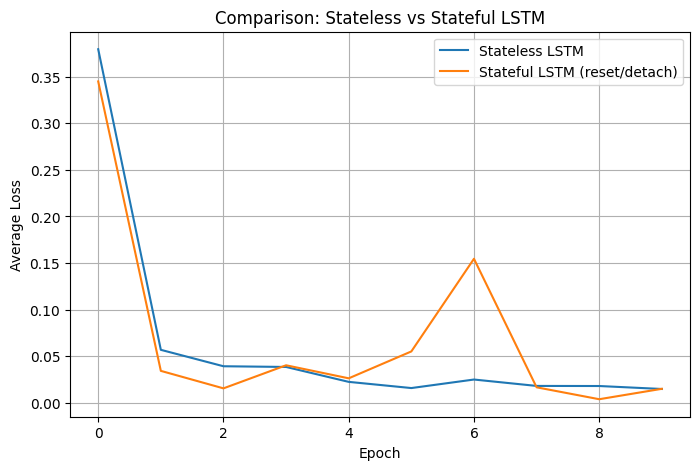

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# -----------------------------------
# สร้างข้อมูลจำลอง (sin wave)
# -----------------------------------
T = 100
x = torch.linspace(0, 8 * 3.1416, T)
y = torch.sin(x)

# สร้าง input-output ลำดับ
seq_len = 5
inputs = torch.stack([y[i:i+seq_len] for i in range(T - seq_len)])
targets = torch.stack([y[i+seq_len] for i in range(T - seq_len)])

inputs = inputs.unsqueeze(-1)  # (batch, seq_len, 1)
targets = targets.unsqueeze(-1)  # (batch, 1)

# -----------------------------------
# สร้างโมเดล LSTM ธรรมดา
# -----------------------------------
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, stateful=False):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.hidden_state = None
        self.stateful = stateful
        self.hidden_size = hidden_size

    def reset_state(self, batch_size):
        self.hidden_state = (
            torch.zeros(1, batch_size, self.hidden_size),
            torch.zeros(1, batch_size, self.hidden_size)
        )

    def detach_state(self):
        if self.hidden_state is not None:
            self.hidden_state = (self.hidden_state[0].detach(),
                                 self.hidden_state[1].detach())

    def forward(self, x):
        if self.stateful and self.hidden_state is not None:
            out, self.hidden_state = self.lstm(x, self.hidden_state)
        else:
            out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# -----------------------------------
# สร้าง model 2 แบบ
# -----------------------------------
model_stateless = SimpleLSTM(1, 32, stateful=False)
model_stateful = SimpleLSTM(1, 32, stateful=True)

criterion = nn.MSELoss()
optimizer1 = torch.optim.Adam(model_stateless.parameters(), lr=0.01)
optimizer2 = torch.optim.Adam(model_stateful.parameters(), lr=0.01)

losses_stateless = []
losses_stateful = []

# -----------------------------------
# Training เปรียบเทียบ
# -----------------------------------
for epoch in range(10):
    # -------- Stateless --------
    total_loss = 0
    for i in range(len(inputs)):
        x_seq = inputs[i].unsqueeze(0)
        y_true = targets[i].unsqueeze(0)

        optimizer1.zero_grad()
        y_pred = model_stateless(x_seq)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer1.step()
        total_loss += loss.item()

    losses_stateless.append(total_loss / len(inputs))

    # -------- Stateful --------
    total_loss = 0
    model_stateful.reset_state(batch_size=1)
    for i in range(len(inputs)):
        x_seq = inputs[i].unsqueeze(0)
        y_true = targets[i].unsqueeze(0)

        optimizer2.zero_grad()
        y_pred = model_stateful(x_seq)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer2.step()

        model_stateful.detach_state()  # <--- ตัดกราฟแต่จำค่าไว้
        total_loss += loss.item()

    losses_stateful.append(total_loss / len(inputs))

# -----------------------------------
# Plot เปรียบเทียบ
# -----------------------------------
plt.figure(figsize=(8,5))
plt.plot(losses_stateless, label='Stateless LSTM')
plt.plot(losses_stateful, label='Stateful LSTM (reset/detach)')
plt.title('Comparison: Stateless vs Stateful LSTM')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
%run setup_path.py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# ==============================
# 1️⃣ RC Tank Environment
# ==============================
class RC_Tank_Env:
    def __init__(self, R=1.5, C=2.0, dt=0.1,
                 control_mode='voltage', setpoint_level=5.0,
                 level_max=10.0, max_action_volt=24.0, max_action_current=5.0):
        self.R = R
        self.C = C
        self.dt = dt
        self.mode = control_mode
        self.setpoint_level = setpoint_level
        self.level_max = level_max
        self.max_action_volt = max_action_volt
        self.max_action_current = max_action_current
        self.level = 0.0
        self.time = 0.0

    def reset(self, default=0.0):
        self.level = float(default)
        self.time = 0.0
        done = False
        return float(self.level), done

    def step(self, action):
        if self.mode == 'voltage':
            action = np.clip(action, 0, self.max_action_volt)
            current = (action - self.level) / self.R
            delta_level = (current / self.C) * self.dt
        elif self.mode == 'current':
            action = np.clip(action, 0, self.max_action_current)
            net_flow = action - (self.level / self.R)
            delta_level = (net_flow / self.C) * self.dt
        else:
            raise ValueError("Invalid control_mode")
        self.level += delta_level
        self.level = np.clip(self.level, 0, self.level_max)
        self.time += self.dt
        done = abs(self.setpoint_level - self.level) <= 0.1
        return float(self.level), bool(done)

# ==============================
# 2️⃣ Signal Generator
# ==============================
class SignalGenerator:
    def __init__(self, t_end=100, dt=0.1):
        self.dt = dt
        self.t_end = t_end
        self.time_array = np.arange(0, t_end, dt)

    def pwm(self, amplitude=1.0, freq=1.0, duty=0.5):
        T = 1 / freq
        signal = amplitude * ((self.time_array % T) < duty * T)
        return self.time_array, signal

# ==============================
# 3️⃣ DeepLSTMRegressor
# ==============================
class DeepLSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1,
                 num_layers=2, fc_units=[128,64], dropout=0.2, stateful=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.stateful = stateful

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        layers = []
        in_features = hidden_size
        for u in fc_units:
            layers.append(nn.Linear(in_features, u))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_features = u
        layers.append(nn.Linear(in_features, output_size))
        self.fc = nn.Sequential(*layers)
        self.hidden_state = None

    def reset_state(self, batch_size=1, device=None):
        if device is None:
            device = next(self.parameters()).device
        self.hidden_state = (
            torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device),
            torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
        )

    def detach_state(self):
        if self.hidden_state is not None:
            self.hidden_state = (self.hidden_state[0].detach(), self.hidden_state[1].detach())

    def forward(self, x):
        if self.stateful and self.hidden_state is not None:
            out, self.hidden_state = self.lstm(x, self.hidden_state)
        else:
            out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

# ==============================
# 4️⃣ สร้าง dataset จาก RC_Tank
# ==============================
env = RC_Tank_Env(control_mode='current', max_action_volt=24, level_max=24, dt=0.1)
sg = SignalGenerator(t_end=1000, dt=0.1)  # ลด t_end สำหรับ train เร็วขึ้น
_, signal = sg.pwm(amplitude=1.0, freq=0.01, duty=0.5)

state_list, action_list, next_state_list = [], [], []

s, _ = env.reset(default=0.0)
for a in signal:
    action = a * env.max_action_volt
    s_next, _ = env.step(action)
    state_list.append([s])
    action_list.append([action])
    next_state_list.append([s_next])
    s = s_next

# normalize input/output
state_array = np.array(state_list) / env.level_max
action_array = np.array(action_list) / env.max_action_volt
next_state_array = np.array(next_state_list) / env.level_max

X = torch.tensor(np.hstack([state_array, action_array]), dtype=torch.float32).unsqueeze(1)
y = torch.tensor(state_array, dtype=torch.float32)

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# ==============================
# 5️⃣ สร้างและ train DeepLSTMRegressor
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepLSTMRegressor(input_size=2, hidden_size=128, output_size=1, fc_units=[128,64], stateful=True).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
loss_list = []

model.train()
for epoch in range(30):
    total_loss = 0
    for xb, yb in dataloader:
        batch_size = xb.size(0)
        model.reset_state(batch_size=batch_size, device=device)  # ⚡ reset hidden state ตาม batch size
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        model.detach_state()  # ⚡ detach state หลัง batch เพื่อไม่ให้ backprop ข้าม batch

    avg_loss = total_loss / len(dataloader)
    loss_list.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss={avg_loss:.6f}")

# ==============================
# 6️⃣ เปรียบเทียบ prediction กับ RC_Tank output
# ==============================
model.eval()
with torch.no_grad():
    model.reset_state(batch_size=X.size(0), device=device)
    y_pred = model(X.to(device)).cpu().numpy().flatten() * env.level_max  # denormalize

plt.figure(figsize=(12,5))
plt.plot(np.arange(len(next_state_list)), np.array(next_state_list).flatten(), label='RC_Tank_Env Output')
plt.plot(np.arange(len(y_pred)), y_pred, label='DeepLSTMRegressor Prediction', alpha=0.7)
plt.xlabel("Time step")
plt.ylabel("Level")
plt.title("RC Tank vs DeepLSTMRegressor Prediction")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch
from pathlib import Path
import pprint # ใช้สำหรับพิมพ์ dictionary สวยๆ

# 1. ระบุตำแหน่งไฟล์โมเดลของคุณ
# -------------------------------------
# อย่าลืมเปลี่ยน path ให้ตรงกับที่เก็บไฟล์ lstm_model.pth ของคุณ

MODEL_PATH = Path(r"D:\Project_end\New_world\my_project\models\lstm_model.pth")

# ตรวจสอบว่าไฟล์มีอยู่จริงหรือไม่
if not MODEL_PATH.exists():
    print(f"❌ Error: ไม่พบไฟล์โมเดลที่ {MODEL_PATH}")
else:
    print(f"✅ กำลังโหลดไฟล์ checkpoint จาก: {MODEL_PATH}\n")

    # 2. โหลดไฟล์ checkpoint
    # -------------------------------------
    # ใช้ map_location='cpu' เพื่อให้แน่ใจว่าสามารถเปิดได้ แม้ในเครื่องที่ไม่มี GPU
    # MODIFIED: เพิ่ม weights_only=False เพื่ออนุญาตให้โหลดอ็อบเจกต์ Python อื่นๆ นอกจาก weights
    checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'), weights_only=False)

    # 3. แสดง Key ทั้งหมดที่มีใน checkpoint
    # -------------------------------------
    print("🔑 Keys ที่มีอยู่ใน Checkpoint:")
    print("-" * 30)
    # เราใช้ pprint เพื่อให้แสดงผลได้อ่านง่ายขึ้น
    pprint.pprint(list(checkpoint.keys()))
    print("-" * 30, "\n")


    # 4. เข้าถึงและแสดงข้อมูลแต่ละส่วน
    # -------------------------------------
    print("🔍 รายละเอียดข้อมูลบางส่วน:")
    print("-" * 30)
    print(f"   - Model Type: {checkpoint.get('model_type', 'N/A')}")
    print(f"   - Learning Rate: {checkpoint.get('learning_rate', 'N/A')}")
    print(f"   - Batch Size: {checkpoint.get('batch_size', 'N/A')}")
    print(f"   - Sequence Size: {checkpoint.get('sequence_size', 'N/A')}")
    print(f"   - Torch Version: {checkpoint.get('torch_version', 'N/A')}")
    print(f"   - Timestamp: {checkpoint.get('timestamp', 'N/A')}")
    print(f"   - Path to Scaling Zip: {checkpoint.get('scaling_zip', 'N/A')}")

    # แสดงข้อมูล loss ของ epoch สุดท้าย
    train_losses = checkpoint.get('train_losses', [])
    if train_losses:
        print(f"   - Final Training Loss: {train_losses[-1]:.6f} (จาก {len(train_losses)} epochs)")

    # แสดงข้อมูล metadata ของ scaler
    scaler_metadata = checkpoint.get('scaler_metadata')
    if scaler_metadata:
        print("\n📄 Scaler Metadata:")
        pprint.pprint(scaler_metadata)

    # แสดงโครงสร้างของ model_state_dict (ดูแค่ layer แรกๆ)
    model_state = checkpoint.get('model_state_dict')
    if model_state:
        print("\n🧠 โครงสร้าง Model State (ตัวอย่าง):")
        for i, (name, param) in enumerate(model_state.items()):
            print(f"   - Layer: {name},   Shape: {param.shape}")
            if i >= 4: # แสดงแค่ 5 layers แรกพอเป็นตัวอย่าง
                print("     ...")
                break
    print("-" * 30)
    for k, v in checkpoint.items():
        if isinstance(v, (int, float, str)):
            print(f"{k}: {v}")

In [ ]:
# =====================================================================
# ⚙️ LSTM INFERENCE SCRIPT (CORRECTED)
# =====================================================================
# This script loads a trained LSTM model and its corresponding scalers
# to perform inference on a newly generated test signal.
#
# CORRECTION:
# The generated signal is now a 2-feature array [time, value]
# to match the input shape expected by the trained model and scaler.
# =====================================================================
%run setup_path.py
import torch
from src.models.lstm_model import VanillaLSTM_MODEL, DeepLSTM_MODEL, BiLSTM_MODEL
from src.data.scaling_loader import ScalingZipLoader
from src.environment.signal_generator import SignalGenerator
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# ==============================================================
# 1. Load checkpoint file
# ==============================================================
MODEL_PATH = Path(r"D:\Project_end\New_world\my_project\models\lstm_model.pth")

# Load checkpoint from file
checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'), weights_only=False)
print("✅ Loaded checkpoint from:", MODEL_PATH)

# ==============================================================
# 2. Extract model configuration from checkpoint
# ==============================================================
model_type = checkpoint["model_type"]
input_dim = checkpoint["input_dim"]
output_dim = checkpoint["output_dim"]
hidden_dim = checkpoint["hidden_dim"]
num_layers = checkpoint["num_layers"]

# Get optional values with fallback defaults
sequence_size = checkpoint.get("sequence_size", 50)
fc_units = checkpoint.get("fc_units", [64, 32])

print(f"🧠 Model Info:\n"
      f"   Type = {model_type}\n"
      f"   Input dim = {input_dim}, Hidden dim = {hidden_dim}, Output dim = {output_dim}\n"
      f"   Num layers = {num_layers}, Sequence size = {sequence_size}, FC units = {fc_units}")

# ==============================================================
# 3. Rebuild the model architecture based on type
# ==============================================================
if model_type == "VanillaLSTM":
    model = VanillaLSTM_MODEL(input_dim, hidden_dim, num_layers, output_dim, fc_units=fc_units)
elif model_type == "DeepLSTM":
    model = DeepLSTM_MODEL(input_dim, hidden_dim, num_layers, output_dim, fc_units=fc_units)
elif model_type == "BiLSTM":
    model = BiLSTM_MODEL(input_dim, hidden_dim, num_layers, output_dim, fc_units=fc_units)
else:
    raise ValueError(f"❌ Unknown model type: {model_type}")

# ==============================================================
# 4. Load trained weights into model
# ==============================================================
missing, unexpected = model.load_state_dict(checkpoint["model_state_dict"], strict=False)
print("⚙️ Missing keys:", missing)
print("⚙️ Unexpected keys:", unexpected)

# Switch to evaluation mode
model.eval()
print("✅ Model loaded successfully and ready for inference!")

# ==============================================================
# 5. Load scaling information for input/output normalization
# ==============================================================
scaler_path = Path(r"D:\Project_end\New_world\my_project\config\Test_scale1_scalers.zip")
print(f"📦 Loading scalers from: {scaler_path}")

scaler_loader = ScalingZipLoader(scaler_path)
scaler_x = scaler_loader.scaler_in
scaler_y = scaler_loader.scaler_out
print(f"scale input: {scaler_x} | scale output: {scaler_y}")

# ==============================================================
# 6. Generate a test signal (sine wave) - ❗️ CORRECTED SECTION ❗️
# ==============================================================
sig_gen = SignalGenerator(t_end=1000, dt=0.01)
t, signal_values = sig_gen.pwm(amplitude=1.0, duty_cycle=0.5, frequency=0.01)
signal_values = signal_values * 24

# --- FIX: Combine time and signal value to create a 2-feature input ---
# Reshape both t and signal_values to be column vectors
t_col = t.reshape(-1, 1)
signal_col = signal_values.reshape(-1, 1)

# Stack them horizontally to create a (n_samples, 2_features) array
# This matches the structure of the training data ('DATA_INPUT', 'DATA_OUTPUT')
signal = np.hstack((t_col, signal_col))

print(f"✅ Corrected signal shape for inference: {signal.shape}")
# --- End of FIX ---

# Normalize using input scaler (this will now work)
signal_scaled = scaler_x.transform(signal)

# ==============================================================
# 7. Model inference (no gradient)
# ==============================================================
sequence_len = sequence_size  # use same length as training

X_seq = []
for i in range(len(signal_scaled) - sequence_len):
    X_seq.append(signal_scaled[i:i + sequence_len])

X_seq = np.array(X_seq)  # shape: (num_samples, seq_len, input_dim)

y_preds = []

with torch.no_grad():
    for seq in X_seq:
        x_input = torch.tensor(seq, dtype=torch.float32).unsqueeze(0)  # (1, seq_len, input_dim)
        y_pred_scaled = model(x_input)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.numpy())
        y_preds.append(y_pred.squeeze())

# Combine all predictions into one array
y_preds = np.array(y_preds)

# Align prediction timeline (start after initial window)
t_pred = t[sequence_len:len(y_preds) + sequence_len]


# ==============================================================
# 8. Display results (continuous prediction)
# ==============================================================
# Note: To plot the original signal, we use the second column of the combined 'signal' array
original_signal_values = signal[:, 1]

print(f"🔹 Predicted output shape: {y_preds.shape}")
print("🔹 Example predictions (first 10):", y_preds[:10].flatten())

plt.figure(figsize=(15, 7))

# --- Raw Input Signal (original)
plt.plot(t, original_signal_values, label="Raw Input Signal (Value)", color='gray', alpha=0.6, linestyle='--')

# --- Predicted Output (inverted)
plt.plot(t_pred, y_preds, label="Predicted Output", color='red', linewidth=2.0)

plt.title("🧠 LSTM Inference: Input Signal vs. Predicted Output")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="upper right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# =====================================================================
# ⚙️ LSTM INFERENCE: AUTOREGRESSIVE MODEL (y_{t+1} = f(y_t, u_t))
# =====================================================================
%run setup_path.py
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from src.models.lstm_model import VanillaLSTM_MODEL
from src.data.scaling_loader import ScalingZipLoader
from src.environment.signal_generator import SignalGenerator

# ==============================================================
# 1. Load model checkpoint
# ==============================================================
MODEL_PATH = Path(r"D:\Project_end\New_world\my_project\models\lstm_model.pth")
checkpoint = torch.load(MODEL_PATH, map_location='cpu', weights_only=False)
print("✅ Loaded checkpoint from:", MODEL_PATH)

# ==============================================================
# 2. Extract model configuration
# ==============================================================
model_type = checkpoint["model_type"]
input_dim = checkpoint["input_dim"]
output_dim = checkpoint["output_dim"]
hidden_dim = checkpoint["hidden_dim"]
num_layers = checkpoint["num_layers"]

# Get optional values with fallback defaults
sequence_size = checkpoint.get("sequence_size", 50)
fc_units = checkpoint.get("fc_units", [64, 32])

print(f"🧠 Model Info:\n"
      f"   Type = {model_type}\n"
      f"   Input dim = {input_dim}, Hidden dim = {hidden_dim}, Output dim = {output_dim}\n"
      f"   Num layers = {num_layers}, Sequence size = {sequence_size}, FC units = {fc_units}")


# ==============================================================
# 3. Rebuild model
# ==============================================================
if model_type == "VanillaLSTM":
    model = VanillaLSTM_MODEL(input_dim, hidden_dim, num_layers, output_dim, fc_units=fc_units)
elif model_type == "DeepLSTM":
    model = DeepLSTM_MODEL(input_dim, hidden_dim, num_layers, output_dim, fc_units=fc_units)
elif model_type == "BiLSTM":
    model = BiLSTM_MODEL(input_dim, hidden_dim, num_layers, output_dim, fc_units=fc_units)
else:
    raise ValueError(f"❌ Unknown model type: {model_type}")
model.load_state_dict(checkpoint["model_state_dict"], strict=False)
model.eval()
print("✅ Model ready for inference")

# ==============================================================
# 4. Load scalers
# ==============================================================
scaler_path = Path(r"D:\Project_end\New_world\my_project\config\Test_scale1_scalers.zip")
scaler_loader = ScalingZipLoader(scaler_path)
scaler_x = scaler_loader.scaler_in
scaler_y = scaler_loader.scaler_out
print("📦 Loaded scalers")

# ==============================================================
# 5. Generate PWM input signal
# ==============================================================
sig_gen = SignalGenerator(t_end=300, dt=0.01)
t, u_signal = sig_gen.pwm(amplitude=1.0, duty_cycle=0., frequency=0.01)
u_signal = u_signal * 24

# ==============================================================
# 6. Autoregressive inference: y_{t+1} = f(y_t, u_t)
# ==============================================================
sequence_len = sequence_size
y_preds = []

# Initialize y_t (e.g., system starts from rest)
y_t = 0.0  

# Simulate step-by-step prediction
for i in range(len(u_signal)):
    # Combine y_t and u_t into input vector
    x_t = np.array([[y_t, u_signal[i]]])  # shape (1, 2)
    
    # Scale input using the same input scaler
    x_scaled = scaler_x.transform(x_t)
    
    # Create sequence buffer for LSTM (repeat same input for seq_len steps)
    seq = np.repeat(x_scaled[np.newaxis, :, :], sequence_len, axis=1)
    x_input = torch.tensor(seq, dtype=torch.float32)
    
    # Predict next output
    with torch.no_grad():
        y_scaled = model(x_input)
        y_next = scaler_y.inverse_transform(y_scaled.numpy())[0, 0]
    
    # Save prediction and update y_t
    y_preds.append(y_next)
    y_t = y_next  # feedback: use predicted output as next input

y_preds = np.array(y_preds)

# ==============================================================
# 7. Visualization
# ==============================================================
plt.figure(figsize=(15, 7))
plt.plot(t, u_signal, label="PWM Input (u_t)", color='gray', linestyle='--', alpha=0.7)
plt.plot(t, y_preds, label="Predicted Output (ŷ_{t})", color='red', linewidth=2)
plt.title("Autoregressive LSTM:  ŷ_{t+1} = f(y_t, u_t)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude / Response")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


✅ Loaded checkpoint from: D:\Project_end\New_world\my_project\models\lstm_model.pth
🧠 Model Info:
   Type = DeepLSTM
   Input dim = 2, Hidden dim = 128, Output dim = 1
   Num layers = 2, Sequence size = 10, FC units = [64, 32]
✅ Model ready for inference
✅ Successfully loaded artifacts from: Test_scale1_scalers.zip
📦 Loaded scalers


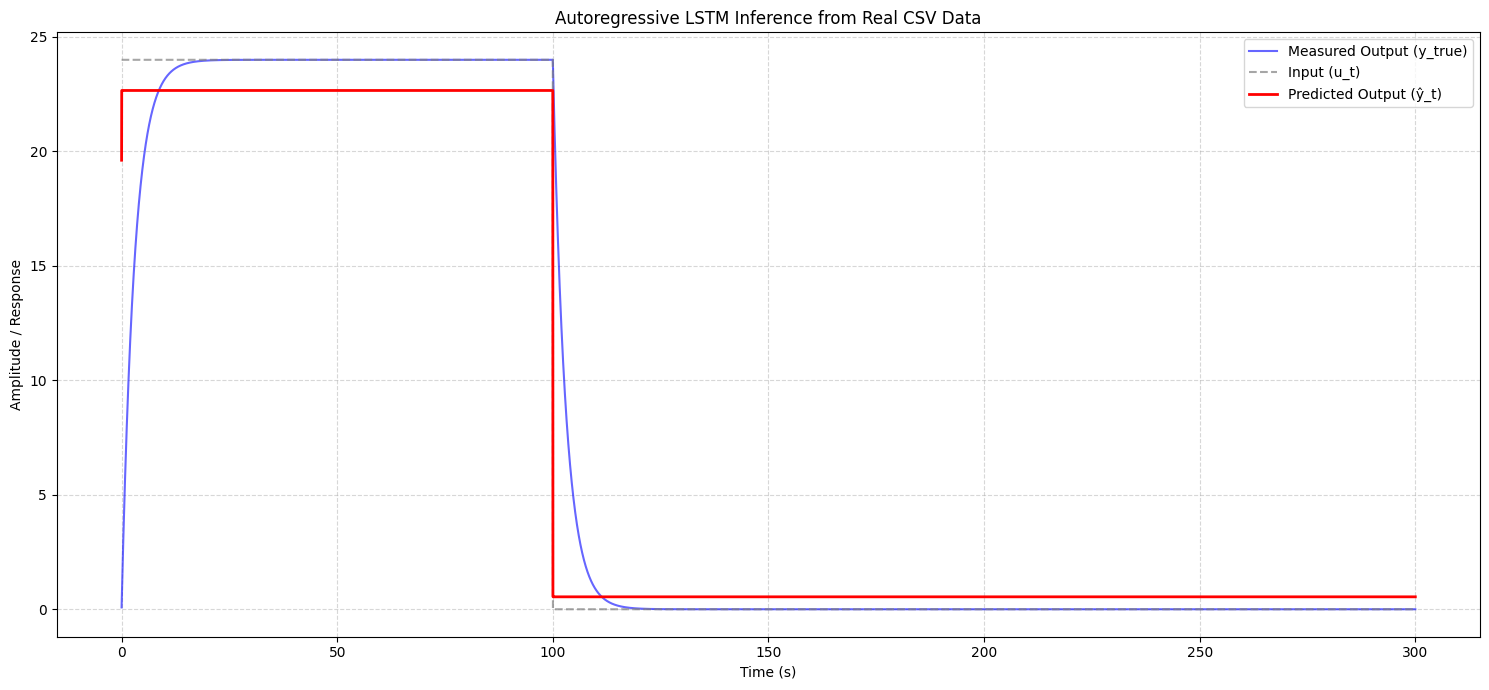


📊 Model Evaluation Results
--------------------------------------------------
📏 MSE  (Mean Squared Error):      5.615135
📏 RMSE (Root Mean Squared Error): 2.369628
📏 MAE  (Mean Absolute Error):     1.130726
📈 R²   (Coefficient of Determination): 0.954068
--------------------------------------------------


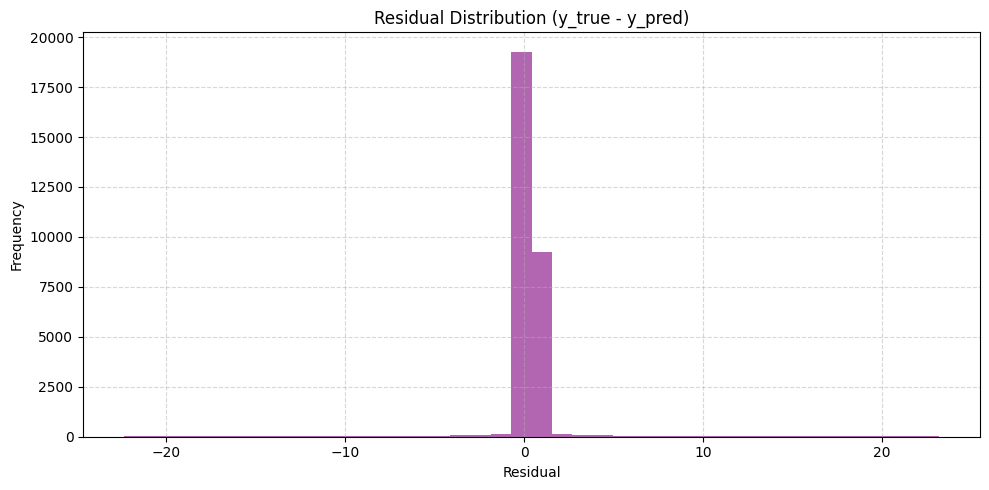

In [13]:
# ==============================================================
# 5. Load signal from CSV file instead of generating PWM
# ==============================================================
%run setup_path.py
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from src.models.lstm_model import VanillaLSTM_MODEL
from src.data.scaling_loader import ScalingZipLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==============================================================
# 1. Load model checkpoint
# ==============================================================
MODEL_PATH = Path(r"D:\Project_end\New_world\my_project\models\lstm_model.pth")
CSV_PATH = Path(r"D:\Project_end\New_world\my_project\data\raw\pwm_duty_0.10_freq_0.00_pwm_amplitude_1_freq_0.001_duty_0.1.csv")
scaler_path = Path(r"D:\Project_end\New_world\my_project\config\Test_scale1_scalers.zip")

checkpoint = torch.load(MODEL_PATH, map_location='cpu', weights_only=False)
print("✅ Loaded checkpoint from:", MODEL_PATH)
# ==============================================================
# 2. Extract model configuration
# ==============================================================
model_type = checkpoint["model_type"]
input_dim = checkpoint["input_dim"]
output_dim = checkpoint["output_dim"]
hidden_dim = checkpoint["hidden_dim"]
num_layers = checkpoint["num_layers"]

# Get optional values with fallback defaults
sequence_size = checkpoint.get("sequence_size", 50)
fc_units = checkpoint.get("fc_units", [64, 32])

print(f"🧠 Model Info:\n"
      f"   Type = {model_type}\n"
      f"   Input dim = {input_dim}, Hidden dim = {hidden_dim}, Output dim = {output_dim}\n"
      f"   Num layers = {num_layers}, Sequence size = {sequence_size}, FC units = {fc_units}")


# ==============================================================
# 3. Rebuild model
# ==============================================================
if model_type == "VanillaLSTM":
    model = VanillaLSTM_MODEL(input_dim, hidden_dim, num_layers, output_dim, fc_units=fc_units)
elif model_type == "DeepLSTM":
    model = DeepLSTM_MODEL(input_dim, hidden_dim, num_layers, output_dim, fc_units=fc_units)
elif model_type == "BiLSTM":
    model = BiLSTM_MODEL(input_dim, hidden_dim, num_layers, output_dim, fc_units=fc_units)
else:
    raise ValueError(f"❌ Unknown model type: {model_type}")
model.load_state_dict(checkpoint["model_state_dict"], strict=False)
model.eval()
print("✅ Model ready for inference")
scaler_loader = ScalingZipLoader(scaler_path)
scaler_x = scaler_loader.scaler_in
scaler_y = scaler_loader.scaler_out
print("📦 Loaded scalers")



# Read CSV file
df = pd.read_csv(CSV_PATH)

# Expecting columns similar to those used in GlobalScalingReference
# e.g. ["DATA_INPUT", "DATA_OUTPUT"]
if not all(col in df.columns for col in ["DATA_INPUT", "DATA_OUTPUT"]):
    raise KeyError("❌ CSV must contain columns: ['DATA_INPUT', 'DATA_OUTPUT']")

# Extract control input (u_t) and measured output (y_t)
u_signal = df["DATA_INPUT"].values
y_true = df["DATA_OUTPUT"].values
t = np.arange(len(u_signal)) * 0.01  # optional time vector (if dt = 0.01)

# ==============================================================
# 6. Autoregressive inference: y_{t+1} = f(y_t, u_t)
# ==============================================================
sequence_len = sequence_size
y_preds = []

# Initialize y_t (use the first actual measurement as the starting point)
y_t = y_true[0]

for i in range(len(u_signal)):
    # Combine y_t and u_t into input vector
    x_t = np.array([[y_t, u_signal[i]]])  # shape (1, 2)
    
    # Scale input
    x_scaled = scaler_x.transform(x_t)
    
    # Create sequence for LSTM
    seq = np.repeat(x_scaled[np.newaxis, :, :], sequence_len, axis=1)
    x_input = torch.tensor(seq, dtype=torch.float32)
    
    # Predict next output
    with torch.no_grad():
        y_scaled = model(x_input)
        y_next = scaler_y.inverse_transform(y_scaled.numpy())[0, 0]
    
    # Store and feedback
    y_preds.append(y_next)
    y_t = y_next

y_preds = np.array(y_preds)
plt.figure(figsize=(15, 7))
plt.plot(t, y_true, label="Measured Output (y_true)", color='blue', alpha=0.6)
plt.plot(t, u_signal, label="Input (u_t)", color='gray', linestyle='--', alpha=0.7)
plt.plot(t, y_preds, label="Predicted Output (ŷ_t)", color='red', linewidth=2)
plt.title("Autoregressive LSTM Inference from Real CSV Data")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude / Response")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
# ==============================================================
# 7. Model Evaluation Metrics
# ==============================================================

# Ensure y_true and y_preds are aligned and same length
min_len = min(len(y_true), len(y_preds))
y_true_eval = y_true[:min_len]
y_pred_eval = y_preds[:min_len]

# Compute common regression metrics
mse = mean_squared_error(y_true_eval, y_pred_eval)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_eval, y_pred_eval)
r2 = r2_score(y_true_eval, y_pred_eval)

print("\n📊 Model Evaluation Results")
print("--------------------------------------------------")
print(f"📏 MSE  (Mean Squared Error):      {mse:.6f}")
print(f"📏 RMSE (Root Mean Squared Error): {rmse:.6f}")
print(f"📏 MAE  (Mean Absolute Error):     {mae:.6f}")
print(f"📈 R²   (Coefficient of Determination): {r2:.6f}")
print("--------------------------------------------------")

# Optional: show residual distribution
residuals = y_true_eval - y_pred_eval
plt.figure(figsize=(10,5))
plt.hist(residuals, bins=40, color='purple', alpha=0.6)
plt.title("Residual Distribution (y_true - y_pred)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

